# Proyecto: Reconocimiento de objetos y conteo salón

## Realizó:
Andrés Felipe Pulido Castro - Código: 20242695004

## Importación de bibliotecas necesarias

In [1]:
# Importar las bibliotecas necesarias
import tensorflow as tf
import numpy as np
import cv2
import os
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


En esta celda importamos las bibliotecas necesarias para el procesamiento de imágenes y la creación del modelo.

## Preparar el conjunto de datos

In [2]:
# Directorio donde están las imágenes organizadas en subcarpetas por clase
image_dir = 'Data'  # Cambia esto a la ubicación correcta de tus imágenes

# Usamos ImageDataGenerator para cargar y etiquetar las imágenes automáticamente
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% de los datos para validación
)

# Cargar las imágenes de entrenamiento usando ImageDataGenerator
train_data = datagen.flow_from_directory(
    image_dir,
    target_size=(224, 224),  # Redimensionar las imágenes a 224x224
    batch_size=32,
    class_mode='sparse',  # Usamos 'sparse' ya que las etiquetas son numéricas
    subset='training',  # Especificamos que este conjunto es para entrenamiento
    shuffle=True
)

# Cargar las imágenes de validación usando ImageDataGenerator
val_data = datagen.flow_from_directory(
    image_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  # Usamos 'sparse' porque las etiquetas son numéricas
    subset='validation',  # Especificamos que este conjunto es para validación
    shuffle=False  # No necesitamos que los datos de validación se mezclen
)

# Mostrar algunas clases para verificar la carga
print(f"Clases: {train_data.class_indices}")


Found 621 images belonging to 6 classes.
Found 152 images belonging to 6 classes.
Clases: {'cpu': 0, 'mesa': 1, 'mouse': 2, 'pantalla': 3, 'silla': 4, 'teclado': 5}


En esta celda usamos ImageDataGenerator para cargar las imágenes desde las subcarpetas del directorio Data. Las carpetas representan las clases (por ejemplo, "cpu", "mesa", "mouse"). Las imágenes se redimensionan a 224x224 píxeles, y las etiquetas se extraen directamente de las carpetas.

## Definir el modelo de red neuronal y su entrenamiento

In [3]:
# Definir el modelo de red neuronal (CNN)
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_data.class_indices), activation='softmax')  # El número de clases depende de las subcarpetas
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con los datos cargados usando ImageDataGenerator
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,  # Usar el generador de datos de validación
    batch_size=32
)





Epoch 1/10


20/20 [==============================] - 27s 1s/step - loss: 2.0069 - accuracy: 0.4074 - val_loss: 0.9189 - val_accuracy: 0.5987
Epoch 2/10
20/20 [==============================] - 25s 1s/step - loss: 0.4541 - accuracy: 0.8454 - val_loss: 0.9805 - val_accuracy: 0.6908
Epoch 3/10
20/20 [==============================] - 26s 1s/step - loss: 0.2198 - accuracy: 0.9259 - val_loss: 0.7459 - val_accuracy: 0.7171
Epoch 4/10
20/20 [==============================] - 25s 1s/step - loss: 0.1218 - accuracy: 0.9581 - val_loss: 0.5646 - val_accuracy: 0.8092
Epoch 5/10
20/20 [==============================] - 27s 1s/step - loss: 0.0351 - accuracy: 0.9903 - val_loss: 0.7568 - val_accuracy: 0.8158
Epoch 6/10
20/20 [==============================] - 27s 1s/step - loss: 0.0237 - accuracy: 0.9903 - val_loss: 0.7388 - val_accuracy: 0.8158
Epoch 7/10
20/20 [==============================] - 30s 1s/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 0.9635 - val_accuracy: 0.7566
Epoch 8/10
20/2

Definimos la arquitectura de la red neuronal convolucional (CNN) con tres capas convolucionales y max-pooling, y la última capa de salida tiene un número de nodos igual al número de clases que estamos tratando de predecir. Adicionalmente, entrenamos el modelo usando las imágenes de entrenamiento y validación. El número de épocas se ha fijado en 10, pero puede ajustarse según sea necesario.

### Análisis de resultados

A partir de los resultados, se observa que la precisión (accuracy) mejora progresivamente a medida que avanzan las épocas, alcanzando un valor muy alto en las últimas épocas. Al principio, la precisión del modelo en el entrenamiento es baja (alrededor de 40%), pero mejora considerablemente a medida que el entrenamiento avanza, llegando a aproximadamente 99.6% al final del décimo ciclo de entrenamiento.

Por otro lado, la precisión de validación (val_accuracy) también muestra una mejora significativa, aunque con cierta fluctuación. Comienza en 59.87% y sube hasta aproximadamente 76.32% al final de las 10 épocas, aunque no se alcanza la precisión de entrenamiento. Esto sugiere que el modelo se está ajustando bien a los datos de entrenamiento, pero podría haber cierto sobreajuste (overfitting), dado que la precisión en la validación no es tan alta como en el entrenamiento. Las pérdidas de validación (val_loss) disminuyen a medida que avanza el entrenamiento, lo que indica que el modelo está aprendiendo a clasificar las imágenes de manera más precisa.

## Evaluación del modelo

5/5 [==============================] - 3s 524ms/step


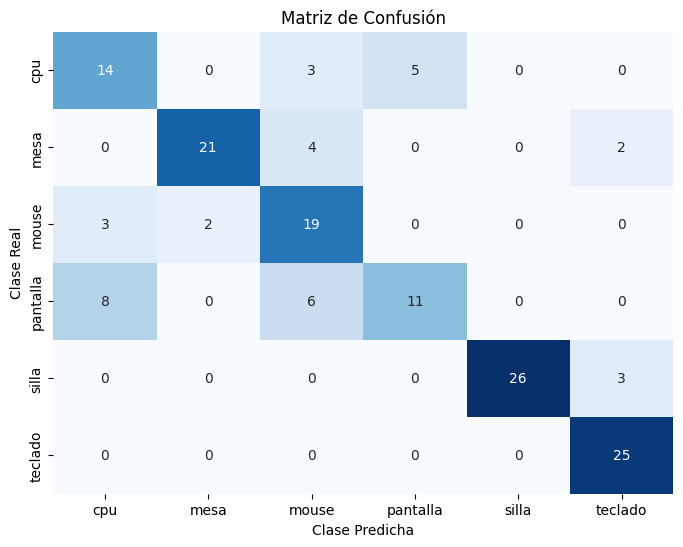

In [4]:
# Obtener las etiquetas verdaderas (y_true) y las predicciones (y_pred)
y_true = val_data.classes  # Las clases reales de las imágenes de validación
y_pred = model.predict(val_data, verbose=1)  # Predicciones del modelo

# Convertir las probabilidades de las predicciones a las clases
y_pred_classes = np.argmax(y_pred, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=val_data.class_indices.keys(), 
            yticklabels=val_data.class_indices.keys(), 
            cbar=False)

plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


Evaluamos el rendimiento del modelo utilizando el conjunto de validación y mostramos la pérdida y la precisión.

### Análisis de resultados

El análisis de la matriz de confusión muestra que el modelo tiene un buen rendimiento general, especialmente en las clases CPU y teclado, con pocos errores en la clasificación. La clase CPU se predice correctamente en 14 ocasiones, aunque comete algunos errores clasificando CPU como pantalla y mouse. De manera similar, el modelo clasifica correctamente teclado en 25 ocasiones, pero comete un error al clasificar teclado como pantalla. En la clase silla, el modelo tiene una alta precisión con 26 predicciones correctas, aunque confunde en 3 ocasiones silla con mesa.

Por otro lado, el modelo muestra ciertas dificultades con las clases pantalla y mouse, con errores notables. La clase pantalla se predice correctamente solo en 11 ocasiones, y el modelo tiende a confundirla con CPU y teclado. Para mouse, el modelo comete algunos errores, clasificando mouse como CPU o pantalla en 5 ocasiones. Aunque el modelo en general es bastante preciso, los resultados sugieren que una mayor cantidad de datos de entrenamiento o ajustes adicionales podrían mejorar el rendimiento en estas clases más problemáticas.

## Guardar el modelo entrenado

In [5]:

model.save('inventario/modelo_inventario.keras')
print("Modelo guardado como modelo_inventario.keras")


Modelo guardado como modelo_inventario.keras


Guardamos el modelo entrenado en un archivo .keras en la carpeta inventario. Asegúrate de que la ruta sea correcta.

## Conversión del modelo a TensorFlow Lite

In [6]:
# Convertir el modelo a TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guardar el modelo TensorFlow Lite en la carpeta 'inventario'
output_path = 'inventario/modelo_inventario.tflite'  # Ruta en la carpeta inventario
with open(output_path, 'wb') as f:
    f.write(tflite_model)

print(f"Modelo convertido y guardado en la carpeta inventario como modelo_inventario.tflite")


INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmpivdezsgu\assets


INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmpivdezsgu\assets


Modelo convertido y guardado en la carpeta inventario como modelo_inventario.tflite


Convertimos el modelo Keras a TensorFlow Lite y lo guardamos en la carpeta inventario como modelo_inventario.tflite.